# Objective

Evaluate and compare the performance of an **SVM** and an **Ensemble Model** on a diabetes dataset.

# Importing the Data

Load the data set and display some info for analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('F:\\school\\bcs\\Machine Learning\\Individual Assignment\\diabetes.csv')
print(data.head())

data.describe

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


<bound method NDFrame.describe of      Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6      148             72             35        0  33.6   
1              1       85             66             29        0  26.6   
2              8      183             64              0        0  23.3   
3              1       89             66             23       94  28.1   
4              0      137             40             35      168  43.1   
..           ...      ...            ...            ...      ...   ...   
763           10      101             76             48      180  32.9   
764            2      122             70             27        0  36.8   
765            5      121             72             23      112  26.2   
766            1      126             60              0        0  30.1   
767            1       93             70             31        0  30.4   

     DiabetesPedigreeFunction  Age  Outcome  
0                       0.627  

# Analysis and Treatment of Data


The dataset under analysis contains multiple features related to health metrics, such as `Glucose`, `BloodPressure`, `SkinThickness`, `Insulin`, and `BMI`, along with the target variable Outcome indicating the presence or absence of diabetes. During the initial exploration of the dataset, it became evident that certain columns, specifically `Glucose`, `BloodPressure`, `SkinThickness`, `Insulin`, and `BMI`, contain missing values, or rather 0. These zeros are biologically implausible for these measurements and likely represent missing or unrecorded data. To ensure the integrity of the dataset, these anomalies need to be addressed through appropriate imputation

Furthermore, an analysis of the `Outcome` variable revealed a significant class imbalance in the dataset: **269 cases**  are labeled as Outcome = 1 (diabetes), while **500 cases** are labeled as `Outcome = 0` (no diabetes). This imbalance means there are nearly twice as many non-diabetic cases as diabetic cases. Such a skewed distribution can lead to biased model predictions, where the model favors the majority class (`Outcome = 0`) at the expense of the minority class (`Outcome = 1`). Proper handling of this imbalance is crucial to ensure fair and accurate performance across both classes. Techniques such as stratified sampling during train-test splitting or oversampling the minority class may be employed to mitigate the effects of this imbalance.

In [3]:
# Percentage of each class
outcome_distribution = data['Outcome'].value_counts(normalize=True) * 100
print(outcome_distribution)


Outcome
0    65.104167
1    34.895833
Name: proportion, dtype: float64


65% of the samples correspond to `no diabetes`, while 35% correspond to `diabetes`, creating a significant class imbalance.

### Identify Zero and Null Values

Zero values in the following columns are not valid and need to be handled:
- `Glucose`
- `BloodPressure`
- `SkinThickness`
- `Insulin`
- `BMI`


In [4]:
# check for 0 and null instances
print(data.isnull().sum())
print(data.eq(0).sum())

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64
Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64


### Replace all 0 values with the median of that category for that outcome

Handling these invalid zeros involves replacing them with the median values for the respective feature. However, a critical nuance here is that the replacement is stratified by the `Outcome` variable. This ensures that the median values used to fill in the missing data are specific to the respective class (`Outcome 0 or 1`). For example, the median `Glucose` for individuals with diabetes (`Outcome = 1`) may differ significantly from those without diabetes (`Outcome = 0`), and failing to stratify could introduce bias into the dataset. By using this approach, the replaced values align more closely with the actual distributions in the data, preserving the relationships between features and the target variable.

In [5]:
# categories to replace 0 values
categories = [
    'Glucose',
    'BloodPressure',
    'SkinThickness',
    'Insulin',
    'BMI'
]

# change to float
data[categories] = data[categories].astype(float)

for category in categories:
    #find median for that category with their respctive outcome
    median_0 = data.loc[data['Outcome'] == 0, category].replace(0, np.nan).median()
    median_1 = data.loc[data['Outcome'] == 1, category].replace(0, np.nan).median()
    
    #replace 0s with respective outcomes median
    data.loc[(data['Outcome'] == 0) & (data[category] == 0), category] = median_0
    data.loc[(data['Outcome'] == 1) & (data[category] == 0), category] = median_1

print(data.eq(0).sum())

Pregnancies                 111
Glucose                       0
BloodPressure                 0
SkinThickness                 0
Insulin                       0
BMI                           0
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64


## Visualize Correletion in features

Once the data is cleaned, it is essential to assess the relationships between features and the target variable to understand their predictive potential. A heatmap is generated to visualize the correlation coefficients between features and `Outcome`.

<Axes: >

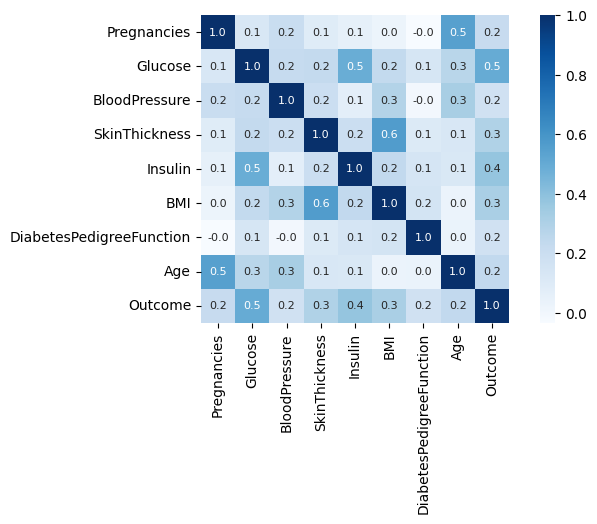

In [6]:
plt.figure(figsize=(8,4))

sns.heatmap(data.corr(), cbar=True, square=True, fmt='.1f', annot=True, annot_kws={'size':8}, cmap='Blues')

`Glucose` demonstrates the strongest positive correlation (0.5), indicating that higher glucose levels are strongly associated with diabetes. Other features, such as `BMI` and `Insulin`, also exhibit moderate correlations, while features like `BloodPressure` and `Age` show weaker relationships. This correlation analysis helps justify the inclusion of these features in the subsequent modeling phase and guides feature engineering efforts.

##### A random number for repetitive testing

In [7]:
r_num = 69 # random number

## Preparing the Data

- **Data Split**: The dataset is split into **80% training** and **20% testing** to evaluate model performance.
- **Stratify**: `stratify` is used to **preserve the class distribution** of the target variable (`Outcome`) between training and testing sets, which is crucial for imbalanced datasets.
- **Scaling**: Features are scaled using `StandardScaler` to ensure all features contribute equally to the model, avoiding dominance by features with larger numerical ranges such as `Glucose`, dominating over those with smaller ranges, such as `DiabetesPedigreeFunction`. 


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#separate features (X) and target (y)
X = data.drop('Outcome', axis=1)  # Outcome is the target column
y = data['Outcome']

# split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=r_num, stratify=y)

# standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Visualisation functions

In [9]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve

# Confusion Matrix 
def plot_confusion_matrix(y_true, y_pred, title, cmap='Blues'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=['No Diabetes', 'Diabetes'], yticklabels=['No Diabetes', 'Diabetes'])
    plt.title(title)
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.show()


# ROC Curve Function
def plot_roc_curve(models, X_test, y_test, titles):
    plt.figure(figsize=(8, 6))
    for model, title in zip(models, titles):
        y_pred_proba = model.predict_proba(X_test)[:, 1]      
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc_score = roc_auc_score(y_test, y_pred_proba)
        plt.plot(fpr, tpr, label=f'{title} (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

# Precision-Recall Curve Function
def plot_precision_recall_curve(models, X_test, y_test, titles):
    plt.figure(figsize=(8, 6))
    for model, title in zip(models, titles):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        plt.plot(recall, precision, label=f'{title}')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()


# Support Vector Machine (SVM) with Grid Search

- **Model Initialization**: An SVM model is initialized with:
  - `probability=True` to enable probability predictions.
  - `class_weight='balanced'` to address class imbalance by assigning weights inversely proportional to class frequencies.

- **Parameter Grid**: A grid of hyperparameters is defined for tuning:
  - `kernel`: Specifies the kernel type (`rbf` and `sigmoid`).
  - `C`: Regularization parameter values to control trade-off between margin size and misclassification.
  - `gamma`: Kernel coefficient for `rbf` and `sigmoid` kernels.

- **Grid Search**: 
  - `GridSearchCV` is used for hyperparameter tuning with:
    - 5-fold cross-validation (`cv=5`).
    - `scoring='roc_auc'` to evaluate models based on their ability to distinguish between classes (AUC-ROC metric).
  - The best model is refitted (`refit=True`) on the training data.

- **Execution**: The model is trained with the specified parameter combinations, and the best-performing hyperparameters are selected.


 

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [11]:
svm_model = SVC(probability=True, class_weight='balanced') 

# define the parameter grid
param_grid_svm = {
    'kernel': ['rbf', 'sigmoid'],
    'C': [0.1, 1, 3, 5, 10, 25],
    'gamma': [1, 0.6, 0.3, 0.1, 0.01],
}

- **Kernel**: Defines the decision boundary's shape. `rbf` and `sigmoid` were selected to allow flexibility.
- **C**: Controls the trade-off between margin size and classification error. Larger values emphasize accurate classification.
- **Gamma**: Determines the influence of each data point in the model. Lower values make the decision boundary smoother.


In [12]:
grid_search_svm = GridSearchCV(svm_model, param_grid_svm, refit=True, verbose=1, cv=5, scoring='roc_auc')
grid_search_svm.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=5, estimator=SVC(class_weight='balanced', probability=True),
             param_grid={'C': [0.1, 1, 3, 5, 10, 25],
                         'gamma': [1, 0.6, 0.3, 0.1, 0.01],
                         'kernel': ['rbf', 'sigmoid']},
             scoring='roc_auc', verbose=1)

### Visualizing Grid Search Results for SVM

- **Prepare Results**: Converted `grid_search_svm.cv_results_` into a DataFrame for visualization.

- **Effect of `C`**:
  - A line plot visualizes the mean test score (ROC AUC) for different values of `C`.
  - Results are grouped by kernel types (`rbf` and `sigmoid`) to show their impact on performance.

- **Effect of `Gamma`**:
  - Another line plot illustrates the mean test score (ROC AUC) for various `gamma` values.
  - Provides insights into how the kernel coefficient (`gamma`) interacts with different kernel types to influence model performance.


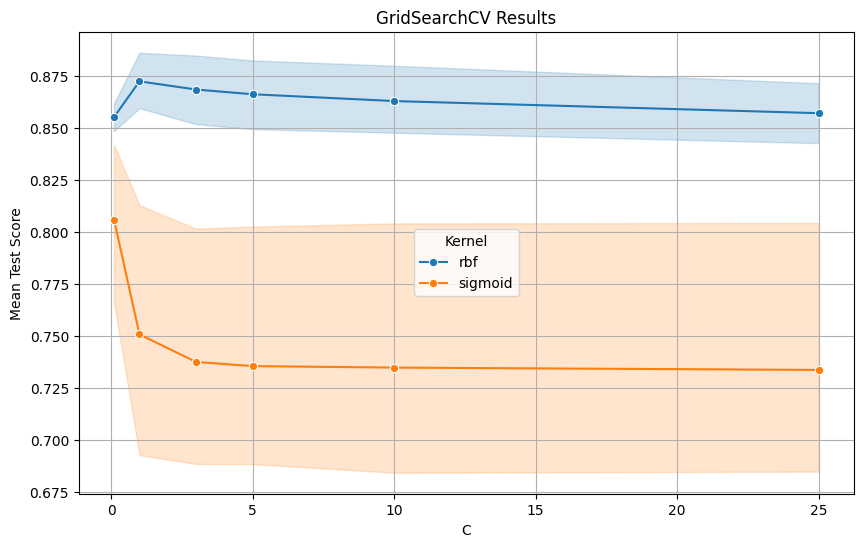

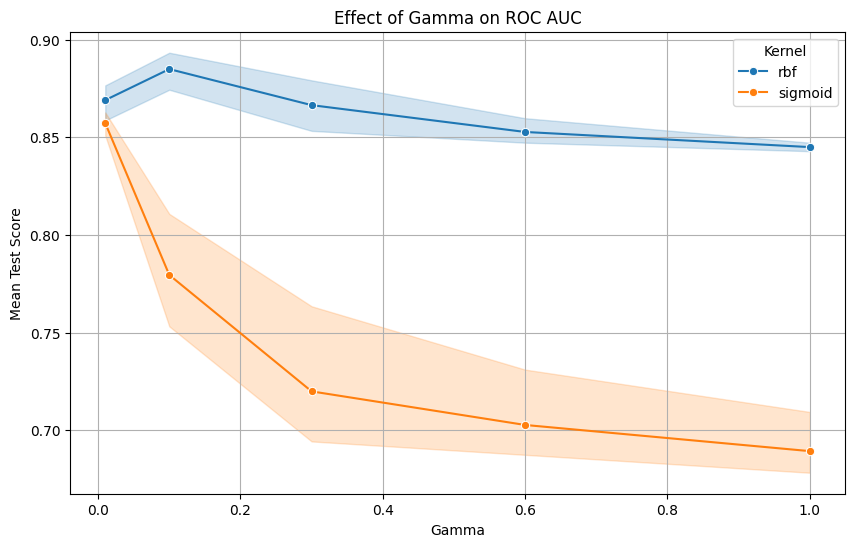

In [13]:
grid_search_results_svm = pd.DataFrame(grid_search_svm.cv_results_)

# Plot the mean test score for each kernel
plt.figure(figsize=(10, 6))
sns.lineplot(data=grid_search_results_svm, x='param_C', y='mean_test_score', hue='param_kernel', marker='o')
plt.title('GridSearchCV Results')
plt.xlabel('C')
plt.ylabel('Mean Test Score')
plt.legend(title='Kernel')
plt.grid()
plt.show()

# Plot the mean test score for each gamma value
plt.figure(figsize=(10, 6))
sns.lineplot(data=grid_search_results_svm, x='param_gamma', y='mean_test_score', hue='param_kernel', marker='o')
plt.title('Effect of Gamma on ROC AUC')
plt.xlabel('Gamma')
plt.ylabel('Mean Test Score')
plt.legend(title='Kernel')
plt.grid()
plt.show()


##### 1. **GridSearchCV Results (Effect of `C` on Mean Test Score)**

- **Key Observations**:
  - The graph demonstrates how the regularization parameter (`C`) affects the performance of the SVM model for two kernels: `rbf` and `sigmoid`.
  - For the **RBF kernel**, performance peaks at \(C = 3\) to \(C = 5\). Beyond this point, the performance slightly declines, indicating that overly high \(C\) values lead to overfitting, which harms generalization.
  - The **Sigmoid kernel** shows consistently lower performance, and its performance worsens as \(C\) increases. This suggests that the Sigmoid kernel is not well-suited to this dataset.

- **Insights**:
  - The **RBF kernel** performs significantly better across all values of \(C\), maintaining higher mean test scores.
  - Optimal regularization occurs at moderate \(C\) values \(C = 3\) to \(C = 5\). Both under-regularization \(C\) too small and over-regularization \(C\) too large negatively impact the model.

---

##### 2. **Effect of `Gamma (γ)` on ROC-AUC**

- **Key Observations**:
  - The graph highlights the impact of the kernel coefficient γ on the model's ability to discriminate between classes, as measured by the ROC-AUC score.
  - For the **RBF kernel**, performance peaks at γ = 0.1 and γ = 0.3. As γ increases, performance drops, likely due to overfitting caused by an overly complex decision boundary.
  - The **Sigmoid kernel** shows poor performance across all values of γ, further reinforcing its unsuitability for this dataset.

- **Insights**:
  - The **RBF kernel** is more robust and adaptable, achieving higher scores across a range of γ values.
  - A moderate γ value provides the best trade-off between bias and variance, resulting in a well-generalized decision boundary.


  


### Evaluating the Best SVM Model

- **Best Parameters**: Extracted optimal hyperparameters using GridSearchCV.
- **Performance Metrics**:
  - **Accuracy**: Achieved a test set accuracy of `best_svm_accuracy_score`.
  - **ROC-AUC**: Scored `best_svm_roc_auc_score`.
  - **Classification Report**: Generated a detailed evaluation of precision, recall, and F1-score.


In [14]:
best_svm_params = grid_search_svm.best_params_
best_svm_model = grid_search_svm.best_estimator_

y_pred_best_svm = best_svm_model.predict(X_test)

# Evaluate the model

best_svm_accuracy_score = accuracy_score(y_test, y_pred_best_svm)
best_svm_classification_report = classification_report(y_test, y_pred_best_svm)
best_svm_roc_auc_score =  roc_auc_score(y_test, y_pred_best_svm)

print("Best Parameters:", best_svm_params)
print("Test Set Accuracy:", best_svm_accuracy_score)
print("ROC-AUC Score:", best_svm_roc_auc_score)
print("\nClassification Report (SVM):\n", best_svm_classification_report)

Best Parameters: {'C': 5, 'gamma': 0.1, 'kernel': 'rbf'}
Test Set Accuracy: 0.8181818181818182
ROC-AUC Score: 0.8088888888888888

Classification Report (SVM):
               precision    recall  f1-score   support

           0       0.88      0.84      0.86       100
           1       0.72      0.78      0.75        54

    accuracy                           0.82       154
   macro avg       0.80      0.81      0.80       154
weighted avg       0.82      0.82      0.82       154



**The classification report provides detailed metrics for both classes:**

- **Class 0 (No Diabetes):**
    - **Precision (0.88):** Of all instances predicted as "No Diabetes," 88% were correct.
    - **Recall (0.84):** Of all actual "No Diabetes" cases, 84% were correctly identified.
    - **F1-Score (0.86):** This harmonic mean of precision and recall shows strong performance in predicting "No Diabetes."

- **Class 1 (Diabetes):**
    - **Precision (0.72):** Of all instances predicted as "Diabetes," 72% were correct.
    - **Recall (0.78):** Of all actual "Diabetes" cases, 78% were correctly identified.
    - **F1-Score (0.75):** While slightly lower than Class 0, this shows acceptable performance in predicting "Diabetes."

- **Overall Metrics:**
    - **Accuracy (0.82):** The model correctly classified 82% of all cases in the test set.
    - **Macro Avg (0.80 for Precision, Recall, F1-Score):** Reflects the average performance across both classes without weighting by class frequency.
    - **Weighted Avg (0.82):** Accounts for the class imbalance by weighting metrics by the number of instances in each class.

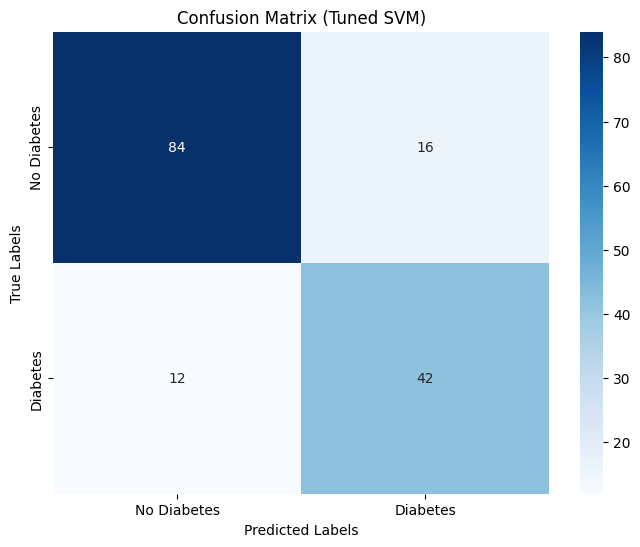

In [15]:
plot_confusion_matrix(y_test, y_pred_best_svm, "Confusion Matrix (Tuned SVM)")

**The confusion matrix provides insight into the model's performance by comparing predicted labels against true labels:**

- **True Negatives (84):** The model correctly predicted "No Diabetes" for 84 cases.

- **False Positives (16):** The model incorrectly predicted "Diabetes" for 16 cases that were actually "No Diabetes."

- **True Positives (42):** The model correctly predicted "Diabetes" for 42 cases.

- **False Negatives (12):** The model incorrectly predicted "No Diabetes" for 12 cases that were actually "Diabetes."

**Key Insight:** The model performs better at identifying "No Diabetes" cases than "Diabetes" cases, this is due to the imbalance favoring "No Diabetes".


# Ensemble Models

In this section, two ensemble methods were selected for evaluation: **Random Forest (RF)** and **Gradient Boosting (GB)**. These models were trained and tuned to identify the best-performing configuration. The best model from these two was then compared against the previously tuned SVM model to determine its relative performance.



In [16]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

## Random Forest with Grid Search

- **Model Initialization**: A Random Forest classifier is initialized with:
  - `random_state=r_num` for reproducibility.
  - `class_weight='balanced'` to handle class imbalance by weighting classes inversely to their frequency.

- **Parameter Grid**: A grid of hyperparameters is defined for tuning:
  - `n_estimators`: Number of trees in the forest (50, 100, 200).
  - `max_depth`: Maximum depth of the trees (`None`, 5, 10, 20).
  - `min_samples_split`: Minimum number of samples required to split an internal node (3, 5, 7).
  - `min_samples_leaf`: Minimum number of samples required to be at a leaf node (1, 2, 4).

- **Grid Search**:
  - `GridSearchCV` is used for hyperparameter optimization with:
    - 5-fold cross-validation (`cv=5`).
    - `scoring='roc_auc'` to evaluate the model based on the AUC-ROC metric.
  - The best model is refitted (`refit=True`) on the training data.

- **Execution**: The model is trained using all combinations of the specified hyperparameters, and the best-performing hyperparameters are selected.


In [17]:
# Grid Search for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 20],
    'min_samples_split': [3, 5, 7],
    'min_samples_leaf': [1, 2, 4]
}

In [18]:
rf_model = RandomForestClassifier(random_state=r_num,)

grid_search_rf = GridSearchCV(rf_model, param_grid_rf, refit=True, verbose=1, cv=5, scoring='roc_auc')
grid_search_rf.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=69),
             param_grid={'max_depth': [None, 5, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [3, 5, 7],
                         'n_estimators': [50, 100, 200]},
             scoring='roc_auc', verbose=1)

### Visualizing Grid Search Results for Random Forest

- **Prepare Results**: Convert `grid_search_rf.cv_results_` into a DataFrame for visualization. Replace `None` in the `param_max_depth` column with the string `'None'` for clarity.

- **Effect of `n_estimators`**:
  - A line plot shows the relationship between the number of estimators (`n_estimators`) and the mean ROC AUC score.
  - Highlights how increasing the number of estimators impacts model performance.

- **Effect of `max_depth` and `n_estimators`**:
  - A heatmap visualizes the mean ROC AUC score across combinations of `max_depth` and `n_estimators`.
  - Provides insights into the interaction between these two hyperparameters.

- **Effect of `min_samples_split` and `max_depth`**:
  - A grouped line plot displays the mean ROC AUC score for different values of `min_samples_split`, grouped by `max_depth`.
  - Helps identify how these hyperparameters jointly influence model performance.


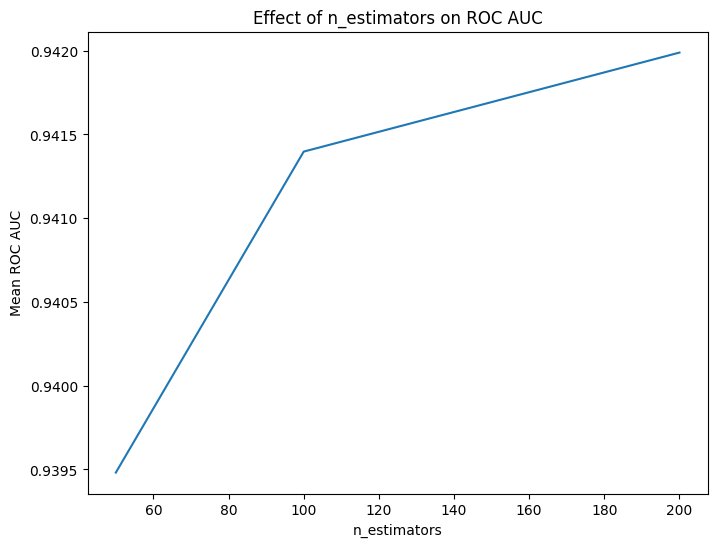

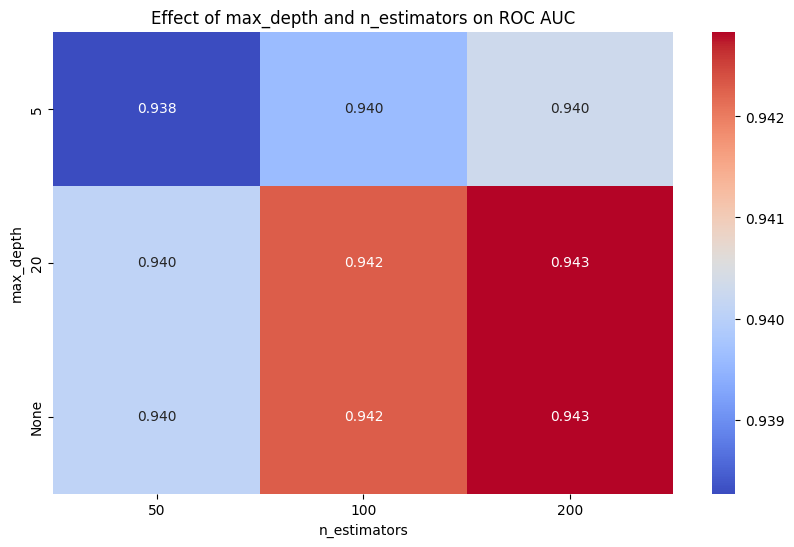

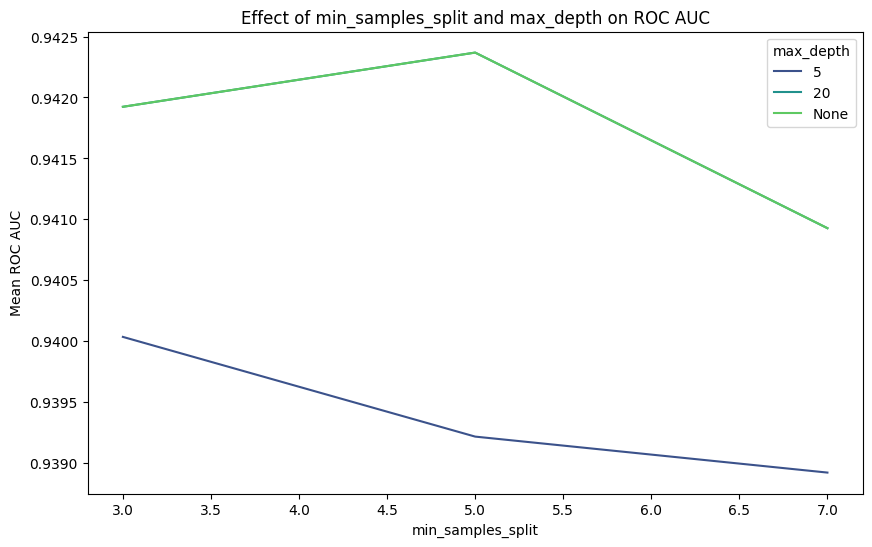

In [19]:
grid_search_results_rf = pd.DataFrame(grid_search_rf.cv_results_)

# Replace None with 'None' in the 'param_max_depth' column for visualization
grid_search_results_rf['param_max_depth'] = grid_search_results_rf['param_max_depth'].apply(lambda x: 'None' if x is None else x)

# Plot effect of 'n_estimators' on ROC AUC
plt.figure(figsize=(8, 6))
sns.lineplot(
    data=grid_search_results_rf.groupby('param_n_estimators').mean(numeric_only=True).reset_index(),
    x='param_n_estimators',
    y='mean_test_score'
)
plt.title('Effect of n_estimators on ROC AUC')
plt.xlabel('n_estimators')
plt.ylabel('Mean ROC AUC')
plt.show()

# Heatmap of 'max_depth' and 'mean_test_score' for a specific 'n_estimators'
heatmap_data = grid_search_results_rf.groupby(['param_max_depth', 'param_n_estimators']).mean(numeric_only=True)['mean_test_score'].unstack()

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap='coolwarm')
plt.title('Effect of max_depth and n_estimators on ROC AUC')
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.show()

# Grouped Line Plot for 'min_samples_split' and 'mean_test_score'
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=grid_search_results_rf.groupby(['param_min_samples_split', 'param_max_depth']).mean(numeric_only=True).reset_index(),
    x='param_min_samples_split',
    y='mean_test_score',
    hue='param_max_depth',
    palette='viridis'
)
plt.title('Effect of min_samples_split and max_depth on ROC AUC')
plt.xlabel('min_samples_split')
plt.ylabel('Mean ROC AUC')
plt.legend(title='max_depth')
plt.show()



### Evaluating the Best Random Forest Model

- **Best Parameters**: Extracted optimal hyperparameters using GridSearchCV.
- **Performance Metrics**:
  - **Accuracy**: Achieved a test set accuracy of `best_rf_accuracy_score`.
  - **ROC-AUC**: Scored `best_rf_roc_auc_score`.
  - **Classification Report**: Detailed evaluation of precision, recall, and F1-score.


In [20]:
best_rf_model = grid_search_rf.best_estimator_
best_rf_params = grid_search_rf.best_params_

y_pred_best_rf = best_rf_model.predict(X_test)

best_rf_accuracy_score = accuracy_score(y_test, y_pred_best_rf)
best_rf_classification_report = classification_report(y_test, y_pred_best_rf)
best_rf_roc_auc_score =  roc_auc_score(y_test, y_pred_best_rf)

print("Best Parameters:", best_rf_params)
print("Test Set Accuracy:", best_rf_accuracy_score)
print("ROC-AUC Score:", best_rf_roc_auc_score)
print("\nClassification Report (Random Forest):\n", best_rf_classification_report)

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 100}
Test Set Accuracy: 0.8831168831168831
ROC-AUC Score: 0.8716666666666667

Classification Report (Random Forest):
               precision    recall  f1-score   support

           0       0.91      0.91      0.91       100
           1       0.83      0.83      0.83        54

    accuracy                           0.88       154
   macro avg       0.87      0.87      0.87       154
weighted avg       0.88      0.88      0.88       154



**The classification report provides detailed metrics for both classes:**

- **Class 0 (No Diabetes):**
    - **Precision (0.92):** Of all instances predicted as "No Diabetes," 92% were correct.
    - **Recall (0.91):** Of all actual "No Diabetes" cases, 91% were correctly identified.
    - **F1-Score (0.91):** This harmonic mean of precision and recall indicates excellent performance in predicting "No Diabetes."

- **Class 1 (Diabetes):**
    - **Precision (0.84):** Of all instances predicted as "Diabetes," 84% were correct.
    - **Recall (0.85):** Of all actual "Diabetes" cases, 85% were correctly identified.
    - **F1-Score (0.84):** Demonstrates strong performance in predicting "Diabetes."

- **Overall Metrics:**
    - **Accuracy (0.89):** The model correctly classified 89% of all cases in the test set.
    - **Macro Avg (0.88 for Precision, Recall, F1-Score):** Reflects the average performance across both classes without weighting by class frequency.
    - **Weighted Avg (0.89):** Accounts for the class imbalance by weighting metrics by the number of instances in each class.

The Random Forest model exhibits robust predictive power, with excellent accuracy and balanced precision and recall across both classes, making it a highly effective model for this dataset.

## Grid Search for Gradient Boosting

- **Model**: Gradient Boosting Classifier initialized with `random_state=r_num` for reproducibility.
- **Hyperparameters**:
  - `n_estimators`: Number of boosting stages, tested at 25, 50, 100, and 200.
  - `learning_rate`: Shrinks the contribution of each tree, tested at 0.01, 0.1, 0.2, and 0.5.
  - `max_depth`: Maximum depth of each tree, tested at 2, 3, 5, and 7.
- **Grid Search**:
  - `GridSearchCV` is used with 5-fold cross-validation (`cv=5`) to evaluate all combinations of hyperparameters.
  - The scoring metric is `roc_auc` (Receiver Operating Characteristic Area Under the Curve).
  - The `refit=True` ensures the best model is retrained on the entire training set.
- **Outcome**: The best combination of hyperparameters is determined to maximize the AUC score.


In [21]:
# Grid Search for Gradient Boosting
param_grid_gb = {
    'n_estimators': [25, 50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2, 0.5],
    'max_depth': [2, 3, 5, 7]
}
gb_model = GradientBoostingClassifier(random_state=r_num) 

grid_search_gb = GridSearchCV(gb_model, param_grid_gb, refit=True, verbose=1, cv=5, scoring='roc_auc')
grid_search_gb.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=69),
             param_grid={'learning_rate': [0.01, 0.1, 0.2, 0.5],
                         'max_depth': [2, 3, 5, 7],
                         'n_estimators': [25, 50, 100, 200]},
             scoring='roc_auc', verbose=1)

### Visualizing Grid Search Results for Gradient Boosting

- **Prepare Results**: Convert `grid_search_gb.cv_results_` into a DataFrame for visualization. Adjust `param_max_depth` to string format for clarity in visualizations.

- **Effect of `n_estimators`**:
  - A line plot illustrates the relationship between the number of estimators (`n_estimators`) and the mean ROC AUC score.
  - Highlights how increasing estimators impacts the model's performance.

- **Effect of `max_depth` and `n_estimators`**:
  - A heatmap visualizes the mean ROC AUC score for combinations of `max_depth` and `n_estimators`.
  - Shows the interaction between tree depth and estimators on model performance.

- **Effect of `learning_rate` and `max_depth`**:
  - A grouped line plot displays the mean ROC AUC score for different values of `learning_rate`, grouped by `max_depth`.
  - Helps evaluate the combined effect of learning rate and tree depth on performance.


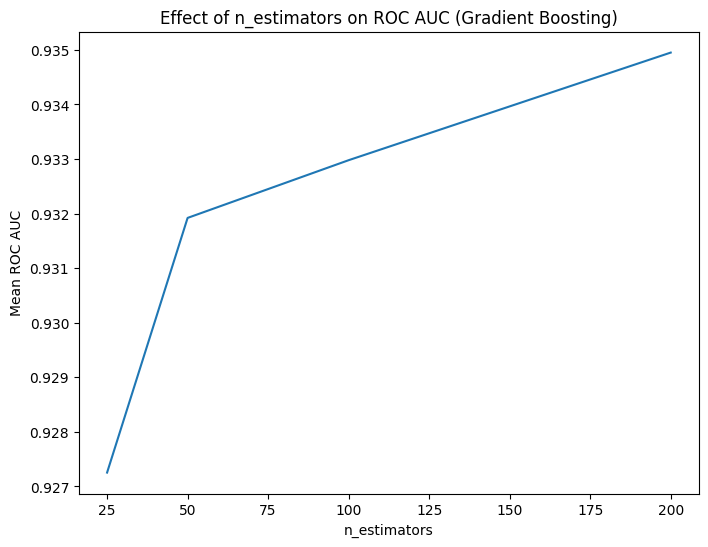

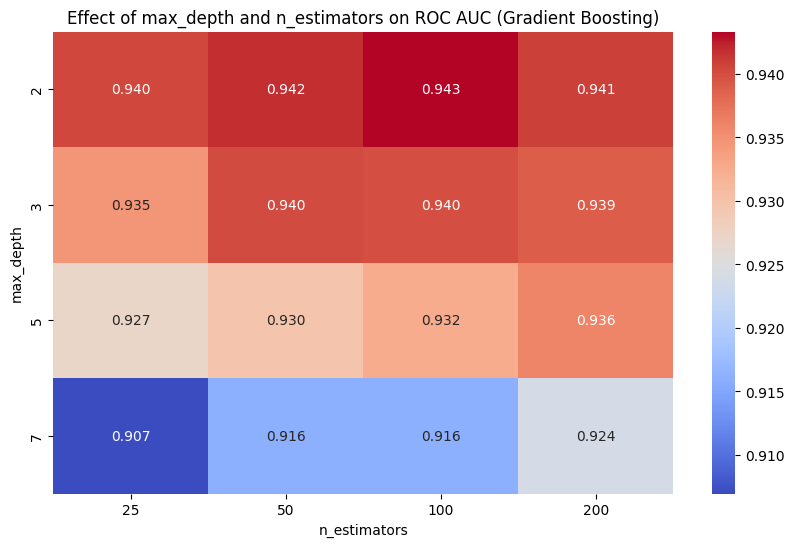

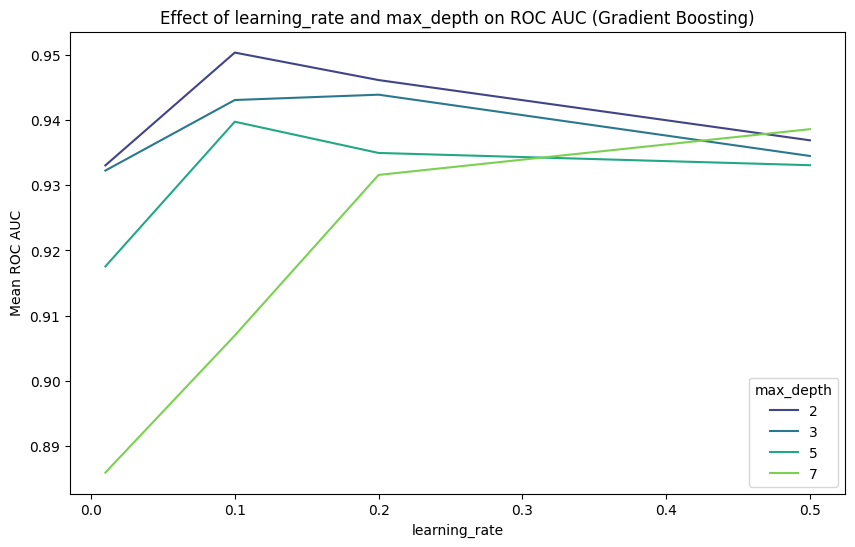

In [22]:
grid_search_results_gb = pd.DataFrame(grid_search_gb.cv_results_)
grid_search_results_gb['param_max_depth'] = grid_search_results_gb['param_max_depth'].astype(str)

# Plot effect of 'n_estimators' on ROC AUC
plt.figure(figsize=(8, 6))
sns.lineplot(
    data=grid_search_results_gb.groupby('param_n_estimators').mean(numeric_only=True).reset_index(),
    x='param_n_estimators',
    y='mean_test_score'
)
plt.title('Effect of n_estimators on ROC AUC (Gradient Boosting)')
plt.xlabel('n_estimators')
plt.ylabel('Mean ROC AUC')
plt.show()

# Heatmap of 'max_depth' and 'mean_test_score' for a specific 'n_estimators'
heatmap_data_gb = grid_search_results_gb.groupby(['param_max_depth', 'param_n_estimators']).mean(numeric_only=True)['mean_test_score'].unstack()

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data_gb, annot=True, fmt=".3f", cmap='coolwarm')
plt.title('Effect of max_depth and n_estimators on ROC AUC (Gradient Boosting)')
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.show()

# Grouped Line Plot for 'learning_rate' and 'mean_test_score'
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=grid_search_results_gb.groupby(['param_learning_rate', 'param_max_depth']).mean(numeric_only=True).reset_index(),
    x='param_learning_rate',
    y='mean_test_score',
    hue='param_max_depth',
    palette='viridis'
)
plt.title('Effect of learning_rate and max_depth on ROC AUC (Gradient Boosting)')
plt.xlabel('learning_rate')
plt.ylabel('Mean ROC AUC')
plt.legend(title='max_depth')
plt.show()

### Evaluating the Best Gradient Boosting Model

- **Best Parameters**: Optimal hyperparameters identified through GridSearchCV.
- **Performance Metrics**:
  - **Accuracy**: Test set accuracy of `best_gb_accuracy_score`.
  - **ROC-AUC**: Achieved a score of `best_gb_roc_auc_score`.
  - **Classification Report**: Comprehensive metrics including precision, recall, and F1-score.

In [23]:
best_gb_model = grid_search_gb.best_estimator_
best_gb_params = grid_search_gb.best_params_

y_pred_best_gb = best_gb_model.predict(X_test)

best_gb_accuracy_score = accuracy_score(y_test, y_pred_best_gb)
best_gb_classification_report = classification_report(y_test, y_pred_best_gb)
best_gb_roc_auc_score =  roc_auc_score(y_test, y_pred_best_gb)

print("Best Parameters:", best_gb_params)
print("Test Set Accuracy:", best_gb_accuracy_score)
print("ROC-AUC Score:", best_gb_roc_auc_score)
print("\nClassification Report (Gradient Boosting):\n", best_gb_classification_report)

Best Parameters: {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 25}
Test Set Accuracy: 0.8766233766233766
ROC-AUC Score: 0.8709259259259259

Classification Report (Gradient Boosting):
               precision    recall  f1-score   support

           0       0.92      0.89      0.90       100
           1       0.81      0.85      0.83        54

    accuracy                           0.88       154
   macro avg       0.86      0.87      0.87       154
weighted avg       0.88      0.88      0.88       154



**The classification report provides detailed metrics for both classes:**

- **Class 0 (No Diabetes):**
    - **Precision (0.92):** Of all instances predicted as "No Diabetes," 92% were correct.
    - **Recall (0.89):** Of all actual "No Diabetes" cases, 89% were correctly identified.
    - **F1-Score (0.90):** Indicates strong overall performance in predicting "No Diabetes."

- **Class 1 (Diabetes):**
    - **Precision (0.81):** Of all instances predicted as "Diabetes," 81% were correct.
    - **Recall (0.85):** Of all actual "Diabetes" cases, 85% were correctly identified.
    - **F1-Score (0.83):** Demonstrates good predictive performance in identifying "Diabetes."

- **Overall Metrics:**
    - **Accuracy (0.88):** The model correctly classified 88% of all cases in the test set.
    - **Macro Avg (0.86 for Precision, 0.87 for Recall, 0.87 for F1-Score):** Reflects the average performance across both classes without weighting by class frequency.
    - **Weighted Avg (0.88):** Accounts for the class imbalance by weighting metrics by the number of instances in each class.

The Gradient Boosting model showcases strong predictive capabilities, particularly in managing class imbalance, with high accuracy and balanced performance across precision and recall for both classes.

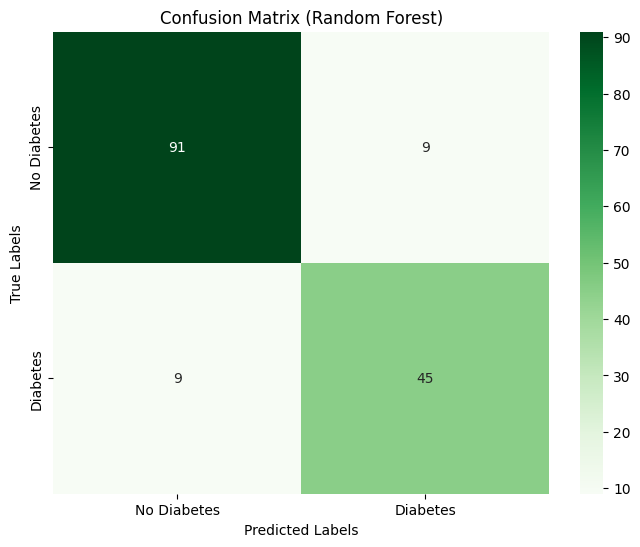

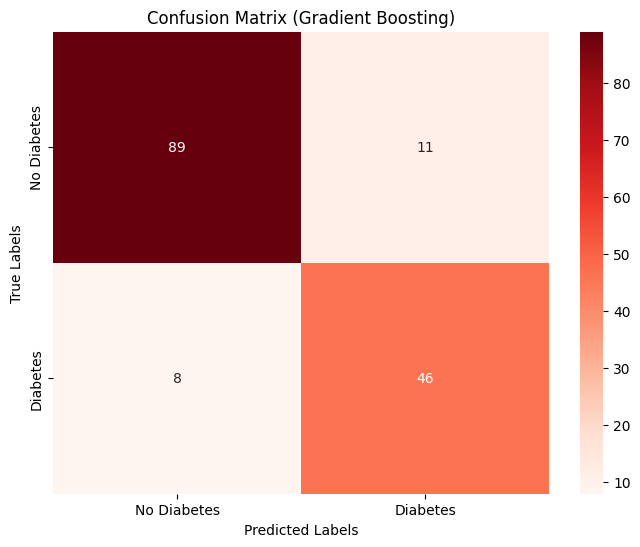

In [24]:
plot_confusion_matrix(y_test, y_pred_best_rf, 'Confusion Matrix (Random Forest)', 'Greens')
plot_confusion_matrix(y_test, y_pred_best_gb, 'Confusion Matrix (Gradient Boosting)', 'Reds')

##### 1- Confusion Matrix Analysis: Random Forest

The confusion matrix below provides insight into the performance of the Random Forest model:

- **True Negatives (91):** The model correctly predicted "No Diabetes" for 91 cases.
- **False Positives (9):** The model incorrectly predicted "Diabetes" for 9 cases that were actually "No Diabetes."
- **True Positives (45):** The model correctly predicted "Diabetes" for 45 cases.
- **False Negatives (9):** The model incorrectly predicted "No Diabetes" for 9 cases that were actually "Diabetes."

**Key Insight:** The Random Forest model demonstrates strong performance, with relatively balanced accuracy in predicting both "No Diabetes" and "Diabetes" cases. Its precision and recall are slightly better for "No Diabetes," likely influenced by the class imbalance.

---

##### 2- Confusion Matrix Analysis: Gradient Boosting

The confusion matrix below highlights the performance of the Gradient Boosting model:

- **True Negatives (89):** The model correctly predicted "No Diabetes" for 89 cases.
- **False Positives (11):** The model incorrectly predicted "Diabetes" for 11 cases that were actually "No Diabetes."
- **True Positives (46):** The model correctly predicted "Diabetes" for 46 cases.
- **False Negatives (8):** The model incorrectly predicted "No Diabetes" for 8 cases that were actually "Diabetes."

**Key Insight:** The Gradient Boosting model slightly outperforms in identifying "Diabetes" cases, with a lower false negative rate compared to the Random Forest model. However, it sacrifices a bit of accuracy in predicting "No Diabetes," as reflected in the higher false positive count. This model balances performance across the two classes more effectively.


#### Select the best Ensemble Model between RF and GB

In [25]:
if  best_rf_roc_auc_score > best_gb_roc_auc_score:
    best_ensemble_model = best_rf_model
    best_ensemble_name = 'Random Forest'
else:
    best_ensemble_model = best_gb_model
    best_ensemble_name = 'Gradient Boost'

y_pred_best_ensemble = best_ensemble_model.predict(X_test)


RF is selected as it slightly out performs GB

# Comparisions

## ROC Curve

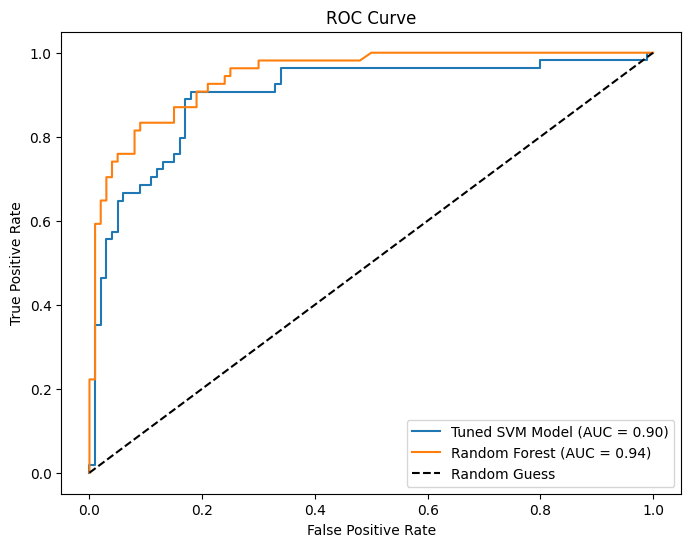

In [26]:
plot_roc_curve([best_svm_model, best_ensemble_model], X_test, y_test, ['Tuned SVM Model', best_ensemble_name])

The ROC (Receiver Operating Characteristic) curve provides a graphical representation of the trade-off between the **True Positive Rate (Sensitivity)** and the **False Positive Rate (1-Specificity)** for the **Tuned SVM Model** and **Random Forest Model**. Towards top-left, the better.

---

#### Key Observations:

1. **Area Under the Curve (AUC)**:
   - **Tuned SVM Model**: AUC = 0.90
   - **Random Forest Model**: AUC = 0.94
   - The Random Forest model outperforms the SVM model with a higher AUC score, indicating a better overall ability to distinguish between the positive and negative classes.

2. **Performance Across Thresholds**:
   - The **Random Forest Model** consistently maintains a higher True Positive Rate at comparable False Positive Rates, showing better classification performance across all decision thresholds.
   - The **Tuned SVM Model**, while effective, lags slightly behind the Random Forest in capturing true positives without increasing false positives.

3. **Diagonal Line (Random Guess)**:
   - The diagonal dashed line represents the performance of a random classifier with an AUC of 0.5. Both models significantly outperform this baseline, indicating strong predictive capabilities.

4. **Low False Positive Rate Region**:
   - The **Random Forest Model** achieves a steeper curve near the origin, demonstrating its ability to achieve a high True Positive Rate while keeping False Positive Rate low. This is particularly important in imbalanced datasets like this one, where false positives must be minimized.

5. **High True Positive Rate Region**:
   - At higher True Positive Rates, the performance gap between the models narrows, but the Random Forest still edges out the SVM model.

---

**Random Forest Model** demonstrates superior classification performance compared to the **Tuned SVM Model**, as evidenced by its higher AUC score (0.94 vs. 0.90) and a better balance of sensitivity and specificity across all thresholds. This makes it the more reliable model for this classification task, especially in scenarios where both sensitivity and specificity are critical.


## Precision-Recall Curve

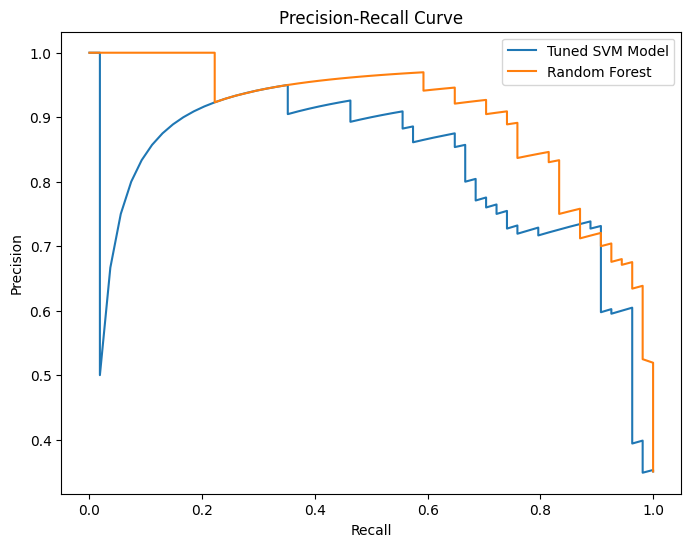

In [27]:
plot_precision_recall_curve([best_svm_model, best_ensemble_model], X_test, y_test, ['Tuned SVM Model', best_ensemble_name])

The precision-recall (PR) curve visualizes the trade-off between precision and recall for the **Tuned SVM Model** and **Random Forest Model** across various threshold values. Towards top-right, the better.

---

#### Key Observations:

1. **Overall Trends**:
   - Both models demonstrate strong precision and recall at certain thresholds, reflecting their ability to balance minimizing false positives and false negatives effectively.
   - The Random Forest curve generally lies above the SVM curve, indicating superior precision-recall trade-offs in certain threshold ranges.

2. **Initial Performance**:
   - At low recall values, Random Forest achieves higher precision compared to the SVM model, suggesting it is more effective at avoiding false positives for highly confident predictions.
   - The SVM model shows a sharp drop in precision initially, likely due to its more aggressive thresholding strategy.

3. **High Recall Region**:
   - As recall increases, the Random Forest curve maintains a steadier decline in precision compared to the SVM curve. This reflects that Random Forest consistently balances precision and recall even as more true positives are included.

4. **Threshold Selection**:
   - For applications where **minimizing false negatives (higher recall)** is critical, Random Forest is the preferred choice as it retains higher precision in this region.
   - If **minimizing false positives (higher precision)** is prioritized, Random Forest still outperforms SVM in the low-recall range.

---

**Random Forest Model** demonstrates a superior precision-recall balance compared to the **Tuned SVM Model** across various thresholds. This makes Random Forest particularly effective for tasks where both precision and recall are equally important or where class imbalance necessitates careful optimization. The SVM model, while still effective, may require further tuning to achieve comparable performance in certain regions.




## Precision, Recall, F1-Score Comparison 

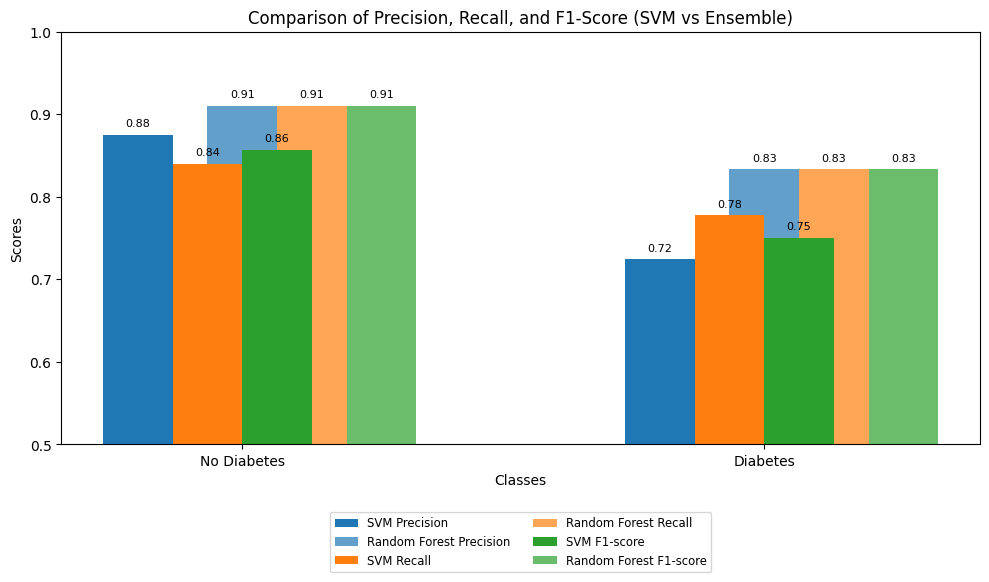

In [28]:
# Extract precision, recall, and F1-score for each class from classification reports
svm_report = classification_report(y_test, y_pred_best_svm, output_dict=True)
ensemble_report = classification_report(y_test, y_pred_best_ensemble, output_dict=True)

# Metrics for each class
metrics = ['precision', 'recall', 'f1-score']
classes = ['0', '1']
classes_label = ['No Diabetes', 'Diabetes']

# Prepare data
svm_metrics = {metric: [svm_report[cls][metric] for cls in classes] for metric in metrics}
ensemble_metrics = {metric: [ensemble_report[cls][metric] for cls in classes] for metric in metrics}

# Bar positioning and width
x = np.arange(len(classes))  # Class indices
width = 0.2  # Width of each bar group

# Colors for metrics
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars
for i, metric in enumerate(metrics):
    ax.bar(
        x - width + i * (width / 1.5),  # Adjusted bar position for SVM
        svm_metrics[metric],
        width / 1.5,
        color=colors[i],
        label=f"SVM {metric.capitalize()}",
    )
    ax.bar(
        x + i * (width / 1.5),  # Adjusted bar position for Ensemble
        ensemble_metrics[metric],
        width / 1.5,
        color=colors[i],
        alpha=0.7,
        label=f"{best_ensemble_name} {metric.capitalize()}",
    )

# Add value labels on each bar
for i, metric in enumerate(metrics):
    for j, cls in enumerate(classes_label):
        svm_value = svm_metrics[metric][j]
        ensemble_value = ensemble_metrics[metric][j]
        # Labels for SVM
        ax.text(
            x[j] - width + i * (width / 1.5),
            svm_value + 0.01,
            f"{svm_value:.2f}",
            ha="center",
            fontsize=8,
        )
        # Labels for Ensemble
        ax.text(
            x[j] + i * (width / 1.5),
            ensemble_value + 0.01,
            f"{ensemble_value:.2f}",
            ha="center",
            fontsize=8,
        )

# Configure axes and title
ax.set_xlabel("Classes")
ax.set_ylabel("Scores")
ax.set_ylim(0.5, 1.0)  # Focus on relevant range
ax.set_title("Comparison of Precision, Recall, and F1-Score (SVM vs Ensemble)")
ax.set_xticks(x)
ax.set_xticklabels(classes_label)  # Use display labels for the x-axis
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2, fontsize="small")

# Tight layout
plt.tight_layout()
plt.show()

### Interpretation of the Bar Chart

The bar chart compares the precision, recall, and F1-score for predicting **"No Diabetes"** and **"Diabetes"** classes using a **Support Vector Machine (SVM)** and the best-performing **Ensemble Model (Random Forest)**.

---

#### **No Diabetes (Class 0)**
- **Precision**:
  - **SVM:** 0.88
  - **Random Forest:** 0.91
  - Random Forest slightly outperforms SVM, indicating better accuracy in identifying "No Diabetes" cases without misclassifying them as "Diabetes."
- **Recall**:
  - **SVM:** 0.84
  - **Random Forest:** 0.91
  - Random Forest captures more actual "No Diabetes" cases than SVM.
- **F1-Score**:
  - **SVM:** 0.86
  - **Random Forest:** 0.91
  - Random Forest achieves a better balance between precision and recall for "No Diabetes."

---

#### **Diabetes (Class 1)**
- **Precision**:
  - **SVM:** 0.72
  - **Random Forest:** 0.83
  - Random Forest significantly outperforms SVM, reducing false positives when predicting "Diabetes."
- **Recall**:
  - **SVM:** 0.78
  - **Random Forest:** 0.83
  - Random Forest identifies more actual "Diabetes" cases than SVM, reducing false negatives.
- **F1-Score**:
  - **SVM:** 0.75
  - **Random Forest:** 0.83
  - Random Forest achieves a consistently higher F1-score, indicating a better balance between precision and recall for "Diabetes."

---

While both models perform well, **Random Forest demonstrates superior precision, recall, and F1-score across both classes.**


# Conclusion

The **Random Forest Model** emerges as the most robust performer overall. It demonstrates a strong balance between precision and recall, achieving superior classification performance across both "No Diabetes" and "Diabetes" classes compared to both the **Gradient Boosting Model** and the **Tuned SVM Model**.

When comparing **Random Forest and Gradient Boosting**, Gradient Boosting slightly outperforms in identifying "Diabetes" cases due to a lower false negative rate but sacrifices some accuracy in predicting "No Diabetes" due to a higher false positive rate. In contrast, Random Forest achieves a more balanced performance across both classes.

Against the **Tuned SVM Model**, Random Forest showcases a higher AUC score (0.94 vs. 0.90) and better precision-recall balance, making it more reliable for tasks requiring a careful optimization of sensitivity and specificity. While the SVM model is effective, Random Forest outperforms it consistently across all key metrics.

